In [363]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances_argmin
import pandas as pd

import fcsparser
from anndata import AnnData

from minisom import MiniSom

In [364]:
# --- CONFIGURATION ---------

filepath = "resources/Levine_13dim.fcs"
som_dim = (10, 10)

# ---------------------------

In [365]:
metadata, data = parse(filepath)

/home/eliasnijs/.local/lib/python3.9/site-packages/fcsparser/api.py:474: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


In [366]:
type(metadata), type(data)

(dict, pandas.core.frame.DataFrame)

In [367]:
adata = AnnData(X=data, obs=metadata)
type(adata)

anndata._core.anndata.AnnData

In [368]:
columns = list(adata.obs.columns)
len(columns)

112

In [369]:
X = adata.X

som = MiniSom(som_dim[0], som_dim[1], X.shape[1], sigma=1.0, learning_rate=0.5)
som.train_batch(X, num_iteration=1000)  # Adjust the number of iterations as desired

# Get the weights from the SOM
som_grid = som.get_weights()

# Calculate the U-Matrix
u_matrix = som.distance_map()

# Find the closest neuron for each sample in the data
winning_neurons = np.array([som.winner(x) for x in X])

# Find the most common label for each neuron
neuron_labels = pd.DataFrame(winning_neurons, columns=["x", "y"])
neuron_labels["label"] = np.argmax(X, axis=1)  # Here we consider the color with the highest intensity as the label

neuron_labels = neuron_labels.groupby(["x", "y"])["label"].agg(lambda x: x.value_counts().index[0]).unstack().values
print(neuron_labels)

# Convert NaN values to -1 (or some other invalid index)
neuron_labels = np.nan_to_num(neuron_labels, nan=-1)

# Convert labels to integers
neuron_labels = neuron_labels.astype(int)

# Convert numerical labels back to color labels
neuron_labels = np.vectorize(lambda x: list(data.columns)[x] if x >= 0 else 'No dominant color')(neuron_labels)

neuron_labels

[[13.  8.  8. 13.  8. 10. 13. nan nan 13.]
 [13. 13. 13. 10. 10. 13. 13. 13. 13. 13.]
 [13.  8. 10. 10. 10. 13. 13. 13. nan nan]
 [13. 13.  8. 10. 10.  8. 13. nan nan 13.]
 [13. 10.  8. 10. 13. 13. 13. nan nan nan]
 [13. 10. 10. 10. 10. 10. nan nan nan 13.]
 [13. 10. 10. 10. 13. 13. nan 13. nan 13.]
 [13. 13. 13. 13. 13. 13. nan nan 13. 13.]
 [13. 13. 13. 13. nan nan nan nan nan nan]
 [nan nan 13. 13. nan nan nan nan nan nan]]


array([['label', 'CD33', 'CD33', 'label', 'CD33', 'CD38', 'label',
        'No dominant color', 'No dominant color', 'label'],
       ['label', 'label', 'label', 'CD38', 'CD38', 'label', 'label',
        'label', 'label', 'label'],
       ['label', 'CD33', 'CD38', 'CD38', 'CD38', 'label', 'label',
        'label', 'No dominant color', 'No dominant color'],
       ['label', 'label', 'CD33', 'CD38', 'CD38', 'CD33', 'label',
        'No dominant color', 'No dominant color', 'label'],
       ['label', 'CD38', 'CD33', 'CD38', 'label', 'label', 'label',
        'No dominant color', 'No dominant color', 'No dominant color'],
       ['label', 'CD38', 'CD38', 'CD38', 'CD38', 'CD38',
        'No dominant color', 'No dominant color', 'No dominant color',
        'label'],
       ['label', 'CD38', 'CD38', 'CD38', 'label', 'label',
        'No dominant color', 'label', 'No dominant color', 'label'],
       ['label', 'label', 'label', 'label', 'label', 'label',
        'No dominant color', 'No domin

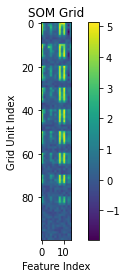

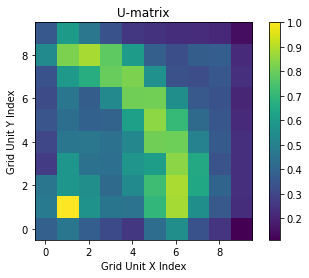

In [370]:
flattened_grid = som_grid.reshape(-1, som_grid.shape[-1])
plt.imshow(flattened_grid)
plt.title("SOM Grid")
plt.colorbar()
plt.xlabel("Feature Index")
plt.ylabel("Grid Unit Index")
plt.show()

plt.imshow(u_matrix, cmap='viridis', origin='lower')
plt.title("U-matrix")
plt.colorbar()
plt.xlabel("Grid Unit X Index")
plt.ylabel("Grid Unit Y Index")
plt.show()

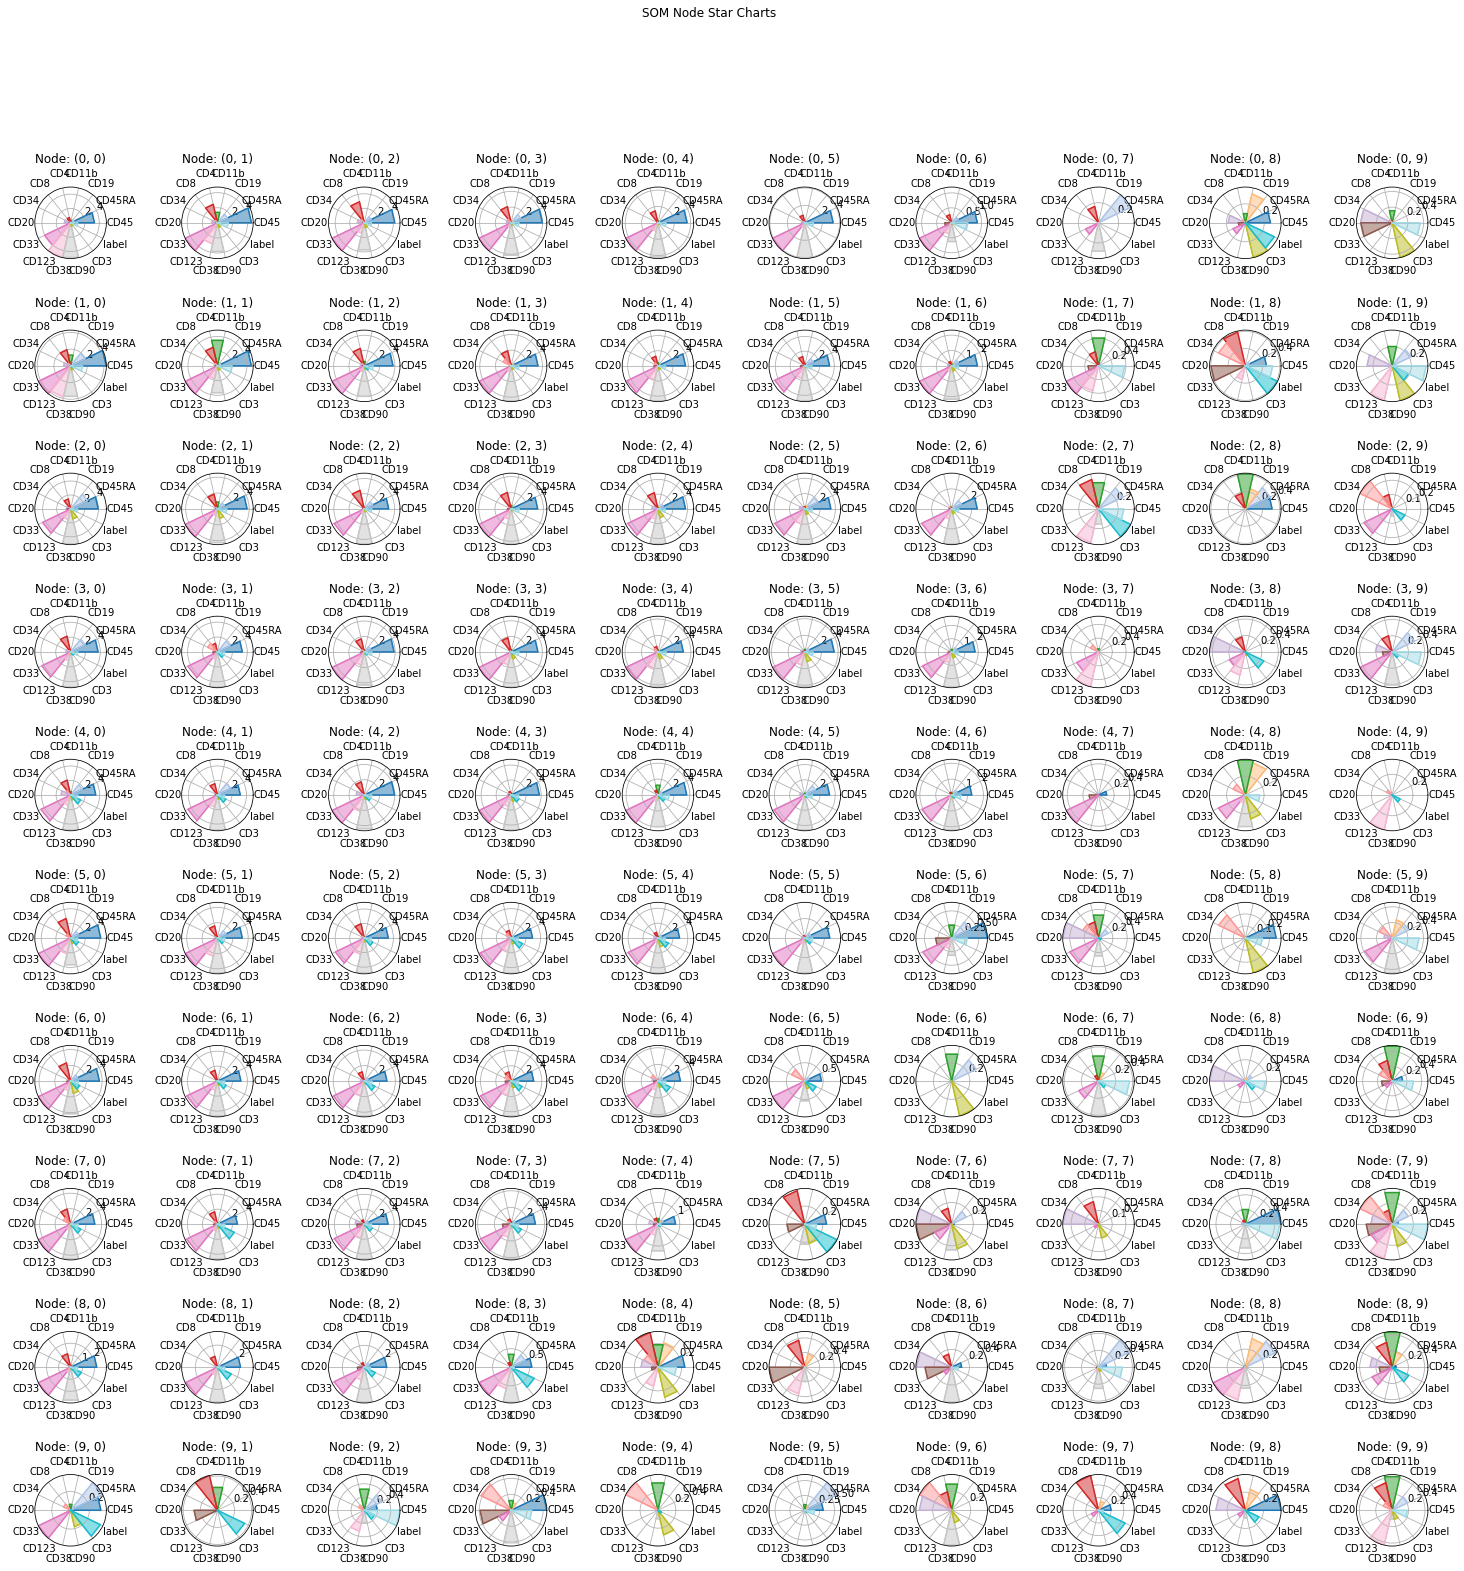

In [371]:
feature_names = list(data.columns)  # Add your feature names
colors = plt.cm.tab20(np.linspace(0, 1, num_features))  # Generate a color map

# Visualize each node as a star chart
num_rows, num_cols, num_features = som_grid.shape
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 25), subplot_kw={'polar': True})
fig.suptitle('SOM Node Star Charts')

plt.subplots_adjust(wspace=1, hspace=1)

for i in range(num_rows):
    for j in range(num_cols):
        node_weights = som_grid[i, j]
        angles = np.linspace(0, 2*np.pi, num_features, endpoint=False).tolist()
        node_weights = np.concatenate((node_weights, node_weights[0:1]))  # Close the loop
        angles += angles[0:1]  # Close the loop

        ax = axes[i, j]
        for k in range(num_features):
            ax.plot([0, angles[k], angles[k + 1], 0], [0, node_weights[k], node_weights[k], 0], color=colors[k])
            ax.fill([angles[k], angles[k + 1], 0], [node_weights[k], node_weights[k], 0], color=colors[k], alpha=0.5)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(feature_names)
        ax.set_title(f'Node: ({i}, {j})')
        ax.set_rorigin(0)  # Centers the plot
        ax.set_ylim(0, np.max(node_weights))  # Adjusts the radius

plt.show()

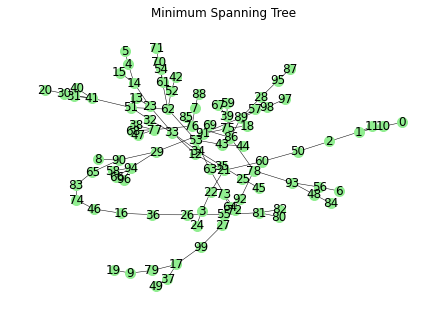

In [372]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

# Assuming you have already created and trained the SOM using MiniSom

# Get the SOM grid
som_grid = som.get_weights()

# Flatten the SOM grid
flattened_grid = som_grid.reshape(-1, som_grid.shape[-1])

# Compute the pairwise distances between nodes
distances = distance_matrix(flattened_grid, flattened_grid)

# Build the Minimum Spanning Tree
mst = minimum_spanning_tree(distances)

# Convert MST to a sparse matrix
mst_sparse = csr_matrix(mst)

# Get the non-zero indices of the sparse matrix
row_indices, col_indices = mst_sparse.nonzero()

# Create a graph from the MST
G = nx.Graph()
for i, j in zip(row_indices, col_indices):
    G.add_edge(i, j)

# Visualize the Minimum Spanning Tree
pos = nx.spring_layout(G)  # Position nodes using a spring layout
nx.draw(G, pos=pos, with_labels=True, node_size=100, node_color='lightgreen', edge_color='black', width=0.5)
plt.title("Minimum Spanning Tree")
plt.show()

/tmp/ipykernel_74927/3446815351.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[grid_y-10:grid_y+10, grid_x-10:grid_x+10], polar=True)


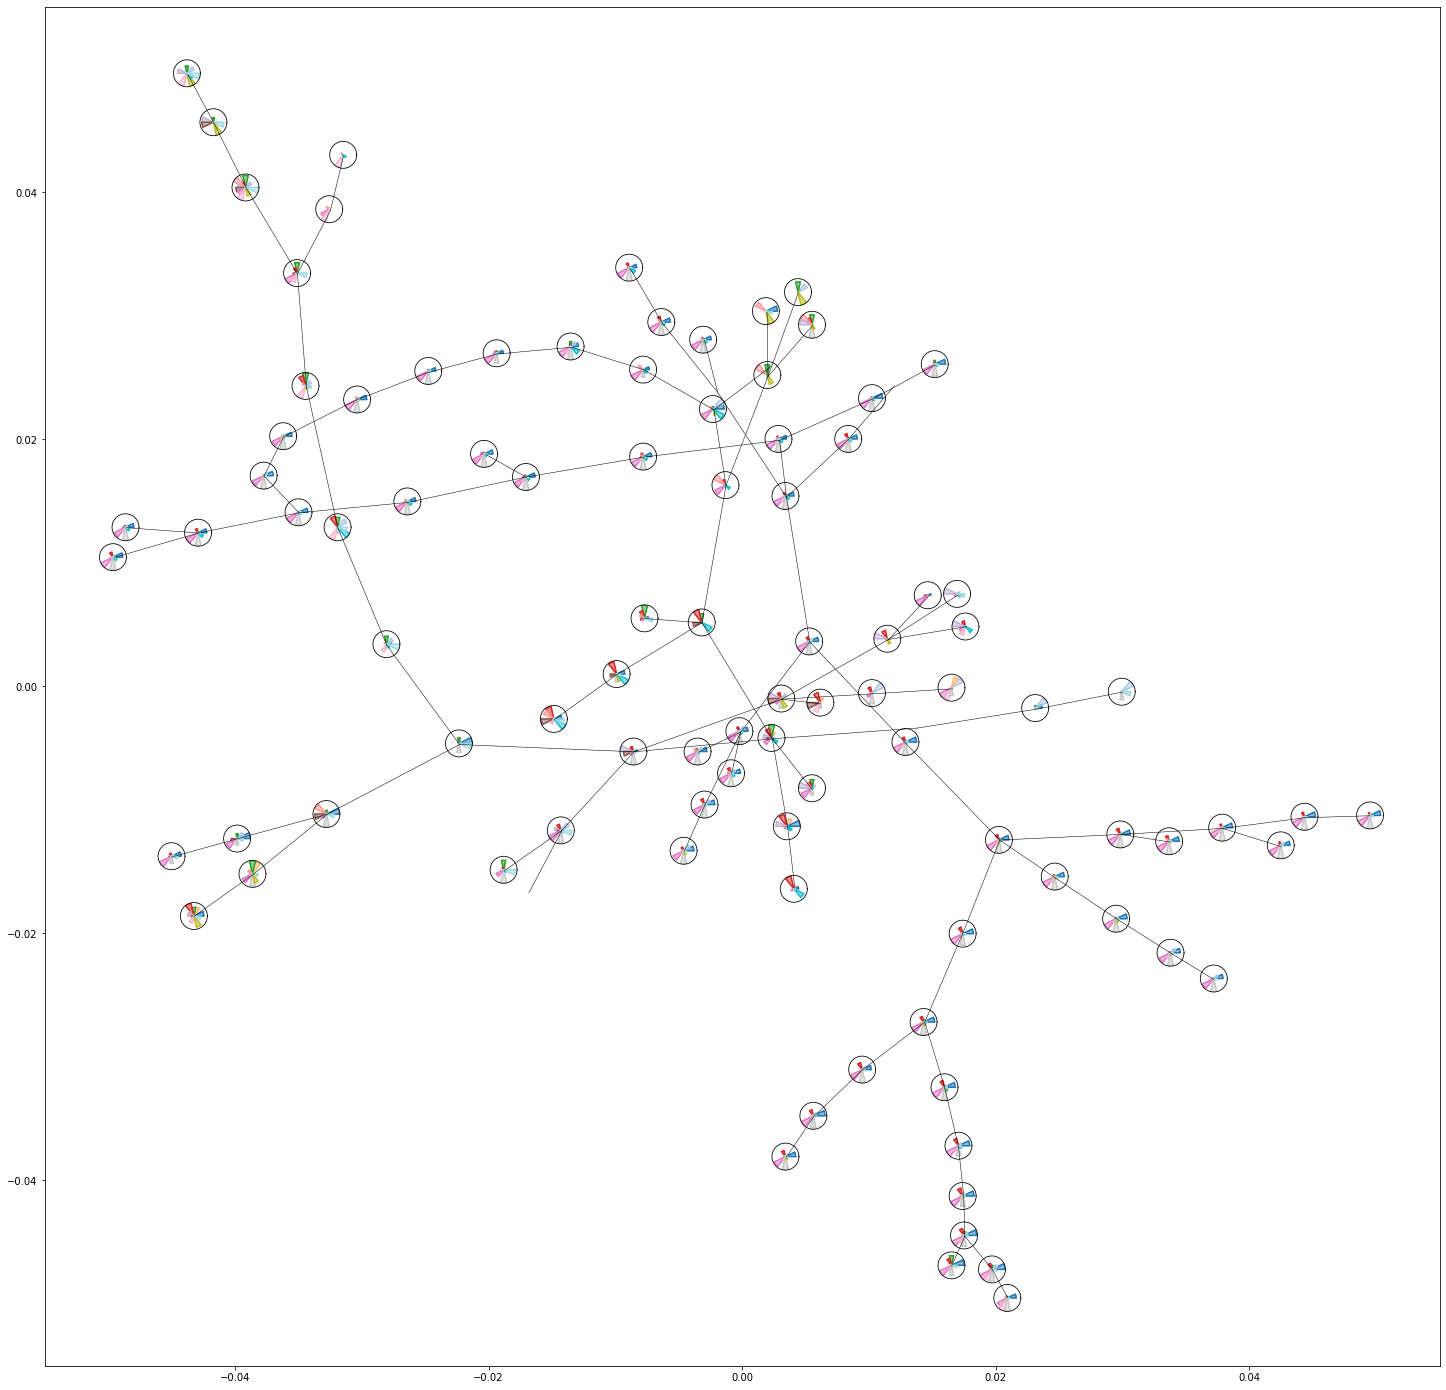

In [404]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# 1. Compute pairwise distances between SOM nodes
# Flatten the SOM grid and compute pairwise Euclidean distances
som_nodes = som_grid.reshape(-1, som_grid.shape[-1])
distances = squareform(pdist(som_nodes))
# som_grid = som.get_weights()
# flattened_grid = som_grid.reshape(-1, som_grid.shape[-1])
# distances = distance_matrix(flattened_grid, flattened_grid)

# 2. Compute the Minimum Spanning Tree (MST)
# Use the distances to compute the MST
mst = minimum_spanning_tree(distances)

# Convert the MST to a dense adjacency matrix
mst_dense = mst.toarray()

# Convert the adjacency matrix to a networkx graph
G = nx.from_numpy_array(mst_dense)

# 3. Determine a layout for the nodes that preserves the MST
# Use the spring layout algorithm from networkx
pos = nx.spring_layout(G, k=0.05)

# Normalize positions to range [0,1] for easier plotting
min_x = min(x for x, y in pos.values())
max_x = max(x for x, y in pos.values())
min_y = min(y for x, y in pos.values())
max_y = max(y for x, y in pos.values())

# Adjust the range to [0.05, 0.95] to add a margin
scale = 0.9  # Scale factor
offset = (1 - scale) / 2  # Offset to center the nodes
pos = {node: (scale * (x - min_x) / (max_x - min_x) + offset, scale * (y - min_y) / (max_y - min_y) + offset)
       for node, (x, y) in pos.items()}

# 4. Draw the polar plots at the positions determined by the layout algorithm
# Use a gridspec to position the subplots
gs = gridspec.GridSpec(1000, 1000)

fig = plt.figure(figsize=(25, 25))
plt.gcf().patch.set_alpha(0)

# Draw the edges
for node, (x, y) in pos.items():
    # Determine the grid position for this node
    grid_x = int(x * 1000)  # Adjust the multiplier to 900
    grid_y = int(y * 1000)  # Adjust the multiplier to 900
    
    ax = plt.subplot(gs[grid_y-10:grid_y+10, grid_x-10:grid_x+10], polar=True)
    ax.set_autoscale_on(False)
    
    # Compute the angles and weights for this node
    angles = np.linspace(0, 2*np.pi, num_features, endpoint=False).tolist()
    node_weights = som_nodes[node]
    node_weights = np.concatenate((node_weights, node_weights[0:1]))  # Close the loop
    angles += angles[0:1]  # Close the loop
    
    # Plot the node
    for k in range(num_features):
            ax.plot([0, angles[k], angles[k + 1], 0], [0, node_weights[k], node_weights[k], 0], color=colors[k])
            ax.fill([angles[k], angles[k + 1], 0], [node_weights[k], node_weights[k], 0], color=colors[k], alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_rorigin(0)
    ax.set_ylim(0, np.max(node_weights))
    
ax_edges = fig.add_subplot(111)
ax_edges.set_facecolor('#00000000')

for edge in G.edges:
    node1, node2 = edge
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    ax_edges.plot([x1, x2], [1-y1, 1-y2], color='k', linewidth=0.5, transform=plt.gca().transAxes)

plt.show()

/tmp/ipykernel_74927/3928734845.py:29: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(consensus_matrix, method='complete')  # You can change 'ward' to 'single', 'complete', etc.


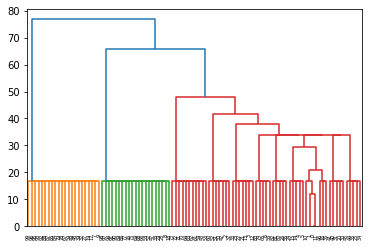

In [420]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Define the number of clusterings and the number of clusters
n_clusters = 14  # Change this to the number of clusters you want

# Initialize the consensus matrix
consensus_matrix = np.zeros((som_nodes.shape[0], som_nodes.shape[0]))

# Generate the clusterings
for _ in range(n_clusterings):
    # Perform hierarchical clustering
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(som_nodes)
    
    # Update the consensus matrix
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if labels[i] == labels[j]:
                consensus_matrix[i, j] += 1
                consensus_matrix[j, i] += 1

# Normalize the consensus matrix
consensus_matrix /= n_clusterings

# Perform hierarchical clustering on the consensus matrix to get the final clustering
Z = linkage(consensus_matrix, method='complete')  # You can change 'ward' to 'single', 'complete', etc.
final_labels = fcluster(Z, n_clusters, criterion='maxclust')

dendrogram(Z)
plt.show()

/tmp/ipykernel_74927/3778869981.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[grid_y-10:grid_y+10, grid_x-10:grid_x+10], polar=True)


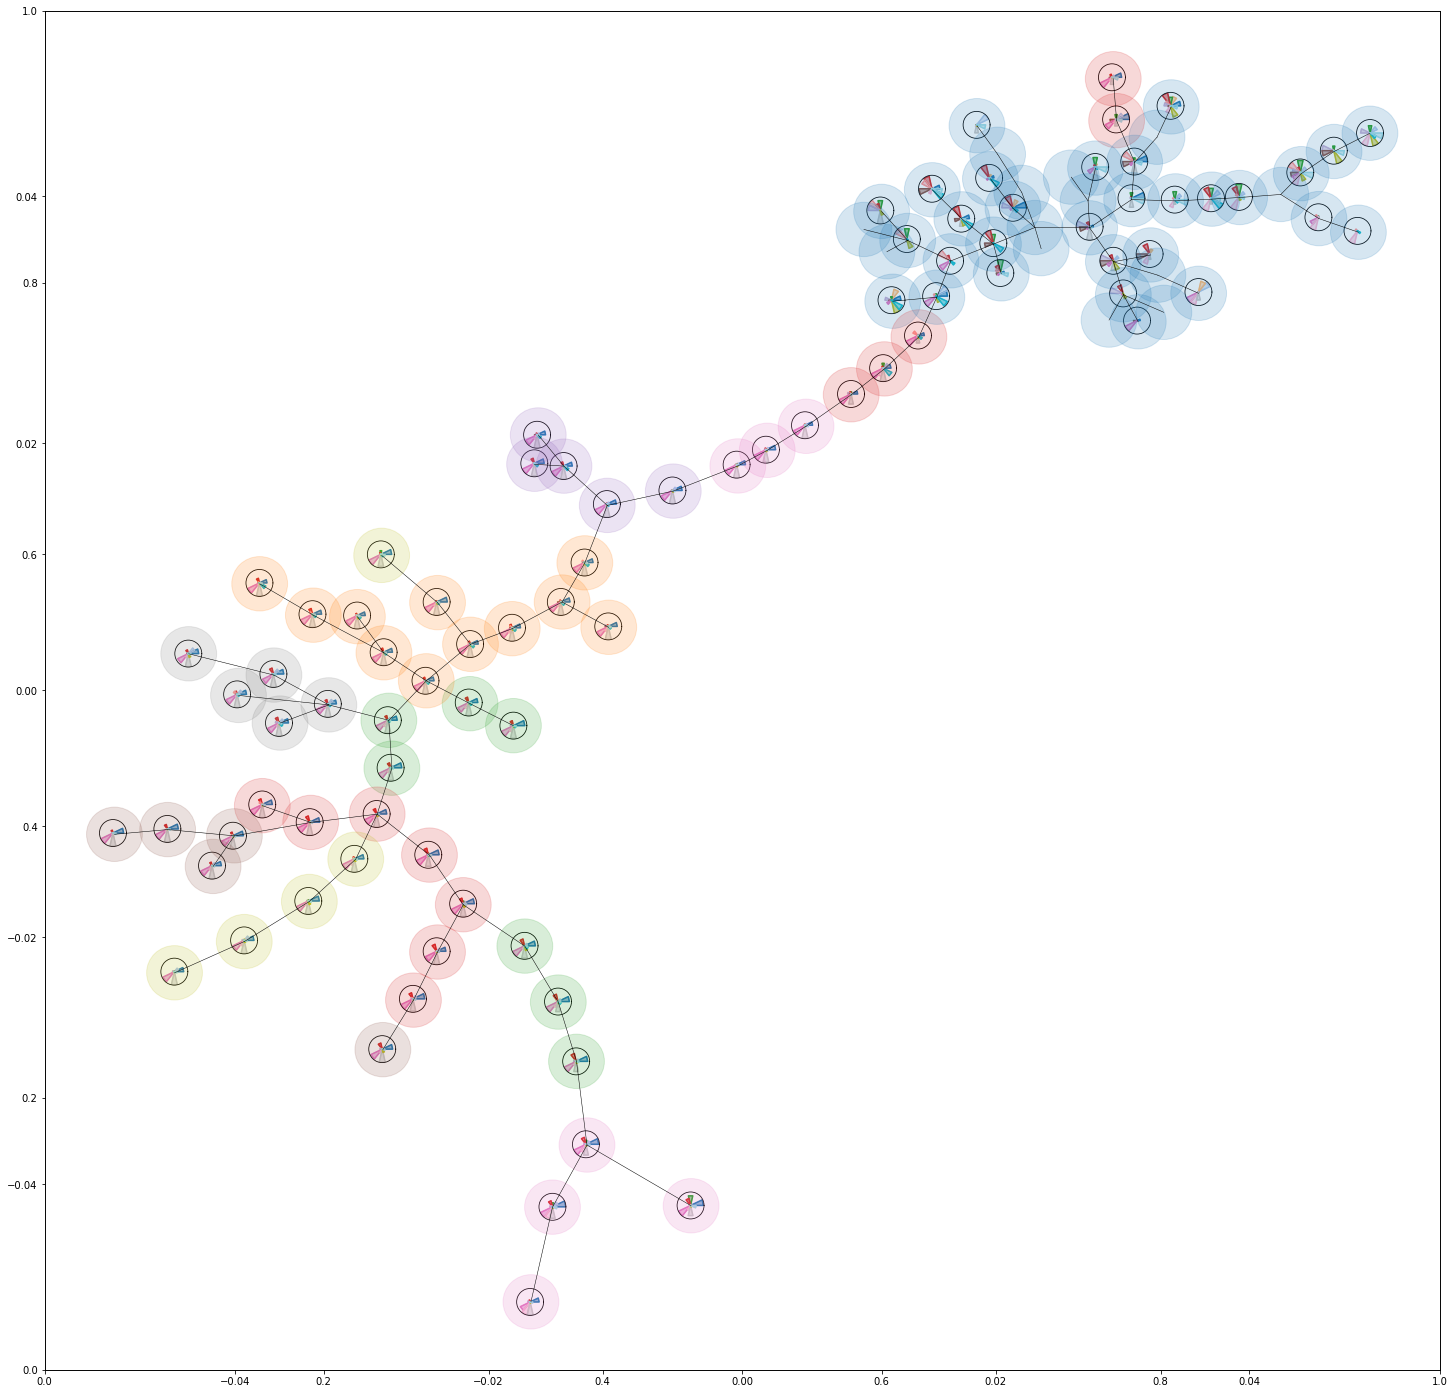

In [425]:
colors = plt.cm.tab20(np.linspace(0, 1, num_features))  # Generate a color map
mcluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# 1. Compute pairwise distances between SOM nodes
som_nodes = som_grid.reshape(-1, som_grid.shape[-1])
distances = squareform(pdist(som_nodes))

# 2. Compute the Minimum Spanning Tree (MST)
# Use the distances to compute the MST
mst = minimum_spanning_tree(distances)

# Convert the MST to a dense adjacency matrix
mst_dense = mst.toarray()

# Convert the adjacency matrix to a networkx graph
G = nx.from_numpy_array(mst_dense)

# 3. Determine a layout for the nodes that preserves the MST
# Use the spring layout algorithm from networkx
pos = nx.kamada_kawai_layout(G)

# Normalize positions to range [0,1] for easier plotting
min_x = min(x for x, y in pos.values())
max_x = max(x for x, y in pos.values())
min_y = min(y for x, y in pos.values())
max_y = max(y for x, y in pos.values())

# Adjust the range to [0.05, 0.95] to add a margin
scale = 0.9  # Scale factor
offset = (1 - scale) / 2  # Offset to center the nodes
pos = {node: (scale * (x - min_x) / (max_x - min_x) + offset, scale * (y - min_y) / (max_y - min_y) + offset)
       for node, (x, y) in pos.items()}

# 4. Draw the polar plots at the positions determined by the layout algorithm
# Use a gridspec to position the subplots
gs = gridspec.GridSpec(1000, 1000)

fig = plt.figure(figsize=(25, 25))
plt.gcf().patch.set_alpha(0)


# Draw the nodes
for node, (x, y) in pos.items():
    # Determine the grid position for this node
    grid_x = int(x * 1000)  # Adjust the multiplier to 900
    grid_y = int(y * 1000)  # Adjust the multiplier to 900
    
    ax = plt.subplot(gs[grid_y-10:grid_y+10, grid_x-10:grid_x+10], polar=True)
    ax.set_autoscale_on(False)
    
    cluster = final_labels[node]
    circle = Circle((x, y), radius=20, color=mcluster_colors[cluster-1], zorder=10)  # Draw a circle with the cluster color
    ax_mclustering.add_artist(circle)
    
    # Compute the angles and weights for this node
    angles = np.linspace(0, 2*np.pi, num_features, endpoint=False).tolist()
    node_weights = som_nodes[node]
    node_weights = np.concatenate((node_weights, node_weights[0:1]))  # Close the loop
    angles += angles[0:1]  # Close the loop
    
    # Plot the node
    for k in range(num_features):
            ax.plot([0, angles[k], angles[k + 1], 0], [0, node_weights[k], node_weights[k], 0], color=colors[k])
            ax.fill([angles[k], angles[k + 1], 0], [node_weights[k], node_weights[k], 0], color=colors[k], alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_rorigin(0)
    ax.set_ylim(0, np.max(node_weights))

ax_mclustering = fig.add_subplot(111)
ax_mclustering.set_facecolor('#00000000')
# Draw the metaclustering
for node, (x, y) in pos.items():
    cluster = final_labels[node]
    circle = Circle((x, 1-y), radius=0.02, color=mcluster_colors[cluster-1], alpha=0.18)  # Draw a circle with the cluster color
    ax_mclustering.add_artist(circle)    

# Draw the edges
ax_edges = fig.add_subplot(111)
ax_edges.set_facecolor('#00000000')
for edge in G.edges:
    node1, node2 = edge
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    ax_edges.plot([x1, x2], [1-y1, 1-y2], color='k', linewidth=0.5, transform=plt.gca().transAxes)

plt.show()